## 分析A/B测试结果


## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)



<a id='intro'></a>
### 简介

首先这个项目数据来自某公司的虚拟数据，主要是了解电子商务网站运行的 A/B 测试的结果。目标是通过这个 notebook 来帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。


<a id='probability'></a>
#### I - 概率

先导入库，然后开始任务。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ** `1.` 现在，导入 `ab_data.csv` 数据，并将其存储在 `df` 中。**

>a. 导入数据集，并在这里查看前几行：

In [2]:
df=pd.read_csv('ab-data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


>b. 使用下面的单元格来查找数据集中的行数。

In [3]:
df.shape[0]

294478

>c. 数据集中独立用户的数量。

In [4]:
len(df['user_id'].unique())

290584

>d. 用户转化的比例。

In [5]:
df['converted'].mean()

0.11965919355605512

>e.  `new_page` 与 `treatment` 不一致的次数。

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'old_page')) == True].shape[0]

3893


>f. 是否有任何行存在缺失值？

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### **`2.` 对于` **treatment**` 不与 `**new_page**` 一致的行或 `**control**` 不与 `**old_page**` 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。所以我们应该删除这些混乱的行。**  

>a. 现在，创建了一个符合要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [5]:
df_1=df[((df['group'] == 'treatment') == (df['landing_page'] == 'old_page'))==True].index
df2=df.drop(df_1)

In [6]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [6]:
df_2=df2[((df2['group'] == 'control') == (df2['landing_page'] == 'new_page')) == True].index
df2=df2.drop(df_2)

In [8]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'new_page')) == True].shape[0]  #df2经过检查，没有混乱的行

0

### `3.` 查看 **df2** 是否还有其他方面的隐藏问题。

>a.  **df2** 中有多少唯一的 **user_id**?

In [11]:
len(df2['user_id'].unique())

290584

>b.  **df2** 中有一个重复的 **user_id** 。它是什么？ 

In [7]:
a=df2.drop_duplicates(subset=['user_id'],keep='first')    #构造去重且保留重复第一行的数据集a
b=df2.drop_duplicates(subset=['user_id'],keep=False)      #构造去重把所有重复行都去掉的数据集b
no_unique=a.append(b).drop_duplicates(subset=['user_id'],keep=False) #a连接上b数据集，再去重其不保留，只剩下单独的之前的‘重复行’
no_unique['user_id']

1899    773192
Name: user_id, dtype: int64

>c. 这个重复的  **user_id** 的行信息是什么？

In [13]:
no_unique

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


>d. 删除 **一个** 含有重复的 **user_id** 的行， 确保 dataframe 为 **df2**。

In [8]:
df2=df2.drop_duplicates(subset=['user_id'],keep='first')

### `4.` 在 **df2** 中查看各种转换率

>a. 不管它们收到什么页面，单个用户的转化率是多少？


In [6]:
df2['converted'].mean()

0.11959667567149027

>b. 假定一个用户处于 `control` 组中，他的转化率是多少？

In [7]:
df2.query('group=="control"')['converted'].mean()

0.1203863045004612

>c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [8]:
df2.query('group=="treatment"')['converted'].mean()

0.11880724790277405

>d. 一个用户收到新页面的概率是多少？


In [9]:
df2.query('landing_page=="new_page"').count()[0]/df2.count()[0]

0.5000636646764286

>### _通过这些概率的分析发现：在数据集中新页面与旧页面占的比例相同，并且两组的转化率都接近0.12，并不能证明新页面能带来更多转化。_



<a id='ab_test'></a>
### II - A/B 测试  

A / B测试中最难的问题：一个页面被认为比另一页页面的效果好得多的时候你就要停止检验吗？还是需要在一定时间内持续发生？你需要将检验运行多长时间来决定哪个页面比另一个页面更好？


`1.` 现在，要考虑的是，需要根据提供的所有数据做出决定。如果想假定旧的页面效果更好，除非新的页面在类型I错误率为5％的情况下才能证明效果更好，那么，零假设和备择假设是什么？ 注：旧页面与新页面的转化率 **$p_{old}$** 与 **$p_{new}$** 来陈述


> H0：P_old - P_new >=0

> H1:  P_old - P_new < 0

`2.` 进行A/B测试注意要求：  
1）假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>
2）每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>
3）执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>
<br><br>

a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是多少？


In [9]:
p_new=df2.query('group=="treatment"')['converted'].mean()
p_new

0.11880806551510564

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是多少？ <br><br>

In [10]:
p_old=df2.query('group=="control"')['converted'].mean()
p_old

0.1203863045004612

c.  $n_{new}$ 是多少？

In [11]:
n_new=df2.query('landing_page=="new_page"').count()[0]
n_new

145310

d.  $n_{old}$?是多少？

In [12]:
n_old=df2.query('landing_page=="old_page"').count()[0]
n_old

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。(提示：可以使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

In [13]:
random.seed(42)

In [14]:
new_page_converted=np.random.choice([0,1],n_new,[1-p_new,p_new])
new_page_converted

array([1, 0, 0, ..., 1, 1, 1])

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [15]:
old_page_converted=np.random.choice([0,1],n_old,[1-p_old,p_old])
old_page_converted

array([1, 1, 0, ..., 1, 1, 0])

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [16]:
new_page_converted.mean()-old_page_converted.mean()

-0.0002203979065243944

h. 使用**a. 到 g. ** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [17]:
p_diffs=[]
for i in range(10000):
    Pnew=np.random.choice([0,1],n_new,[1-p_new,p_new]).mean()
    Pold=np.random.choice([0,1],n_old,[1-p_old,p_old]).mean()
    p_diffs.append(Pnew-Pold)

i. 绘制一个 **p_diffs** 直方图。

(array([3.000e+00, 2.100e+01, 2.160e+02, 9.030e+02, 2.162e+03, 3.042e+03,
        2.317e+03, 1.048e+03, 2.540e+02, 3.400e+01]),
 array([-0.00799081, -0.006553  , -0.0051152 , -0.00367739, -0.00223958,
        -0.00080178,  0.00063603,  0.00207384,  0.00351164,  0.00494945,
         0.00638726]),
 <a list of 10 Patch objects>)

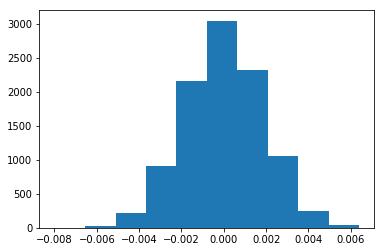

In [18]:
plt.hist(p_diffs)

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

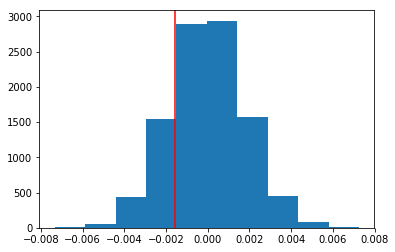

In [24]:
null_vals=np.random.normal(0,np.std(p_diffs),10000)
obs_diff1=df2.query('landing_page=="new_page"')['converted'].mean()-df2.query('landing_page=="old_page"')['converted'].mean()
plt.hist(null_vals)
plt.axvline(obs_diff1,color='red')

In [25]:
p=(null_vals>obs_diff1).mean()
p

0.8062

> k.这个P值表示统计显著性，接近1，说明拒接零假设的风险很大，即接受零假设，新旧页面转化率没有区别。

l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。尽管使用内置程序可能更易于编写代码，但上面的内容是对正确思考统计显著性至关重要的思想的一个预排。填写下面的内容来计算每个页面的转化次数，以及每个页面的访问人数。使用 `n_old` 与 `n_new` 分别引证与旧页面和新页面关联的行数。

In [29]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page"')['converted'].sum()
convert_new = df2.query('landing_page=="new_page"')['converted'].sum()
n_old = df2.query('landing_page=="old_page"').count()[0]
n_new = df2.query('landing_page=="new_page"').count()[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. 现在使用 `stats.proportions_ztest` 来计算检验统计量与 p-值。

In [30]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

 >根据上题算出的 z-score <1.96和 p-value>0.05，认为差异不显著，新旧页面的转化率没有区别。它们与 **k.** 中的结果一致.

## 结论：经过两遍的显著性差异检验，发现数据中新旧页面对转化率的影响十分小，可以忽略。